# Episode 4 -- Quantiles and Outliers

* Classical summary statistics good for describing the body of the distribution
* Need information about the tail of the distributions, e.g. for writing good SLAs
* Determine outliers in a dataset

In [3]:
import math
import random
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
mpl.rcParams['figure.figsize'] = (15,5)
%matplotlib inline
X = np.loadtxt("DataSets/RequestRates.csv", delimiter=",")[:,1]

# Comulative Distribution Functions

The (empirical) cumulative distribution function of a dataset $X$, is defined as:

$$ CDF(y) = \# \{ i \, | \, x_i \leq y \} / \# X $$

So CDF(y) = the ratio of samples that are lower than $y$.

In [4]:
def CDF(y,X):
    lower_count = 0
    for x in X:
        if x <= y: lower_count += 1
    return float(lower_count) / len(X)

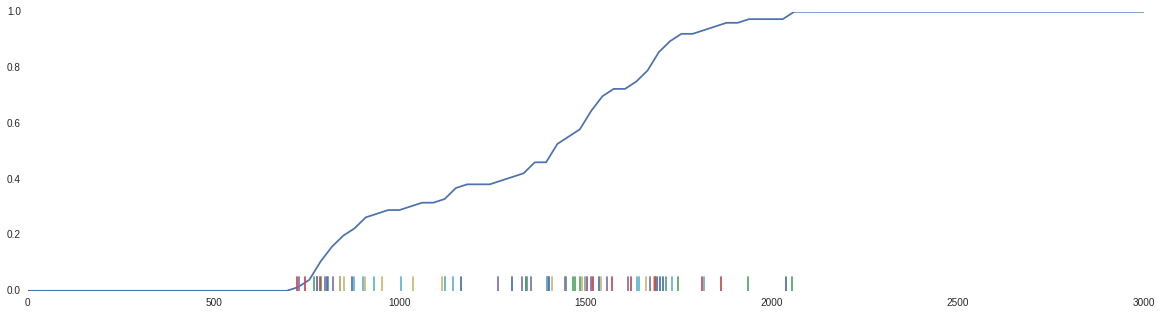

In [5]:
grid = np.linspace(0,3000,100)
plt.figure(figsize=(20,5))
plt.plot(grid, [CDF(y,X) for y in grid])
sns.rugplot(X)

Properties:

* $0 \leq CDF(y) \leq 1$
* CDF is monotonically increasing

## Example: Using CDF to monitor SLAs

CDFs can be used to determine service levels.

1. Measure response time latencies each minute over 1h
2. Calculate `CDF(<max tolerable latency>)` for each 1h window
3. Good service when `CDF = 1`


<figure>
<img src="img/example_cdf_sla.png">
<figcaption>CDF(0.05) over 1h windows for Twitter Ping Latencies</figcaption>
</figure>

* share: https://share.circonus.com/shared/graphs/65d896dd-2be3-4be9-a76d-6fec209358b1/ZrBa3u
* graph: https://parlette.circonus.com/trending/graphs/view/65d896dd-2be3-4be9-a76d-6fec209358b1#no-set

## Example: CDF for a histogram metric

* Histograms are a much better representation of actual API usage
* Calculate CDF over all requestst that arrived in 1h
* Catch delays that affect only a small fraction of the requests

<figure>
<img src="img/example_histogram_IVP.png">
<figcaption>Histogram metric with CFD(3) over 1h windows</figcaption>
</figure>

* share:https://share.circonus.com/shared/graphs/0455bb94-1fbd-4128-9364-41d756d98933/iZntwd

* graph: https://circonus-ops.circonus.com/trending/graphs/view/0455bb94-1fbd-4128-9364-41d756d98933#no-set

# Quantiles and Percentiles

* Complement or Inverse to CDFs:
  - CDF: The ratio of samples was below 100 was `<CDF>`
  - Quantile: 90% of all queries where faster than `<quantile>`
* Qunatile parameter is indpendent of value range

Examples:

* The minimum is a 0-quantile
* A median is a 0.5-quantile
* The maximum is a 1-quantile

Special names:

* Quartiles: $k/4$-quantiles
* Percentiles: $k/100$-quantiles

### Median

A _median value_ for $x_1, \dots, x_n$ is number $m$ such that
  
 $$ \# \{ i \,|\, x_i \leq m \} = \# \{ i \,|\, x_i \geq m \}. $$

So the number of samples smaller than $m$ is equal to the number of samples larger than $m$.
(Both should be roughly $n/2$).
  
Remark:

* A Median always exists
* Median is not unique
* Can be computed in linear time
* Not influenced by outliers (robust)

In [58]:
# Computation of the median

def median_range(X):
    S = sorted(X)
    n = len(X) # S[0] < ... < S[n-1]
    lower_mid = int(math.floor((n-1)/2.))
    upper_mid = int(math.ceil((n-1)/2.))
    return (S[lower_mid], S[upper_mid])

def plot_median_range(X):
    plt.figure(figsize=(20,5))
    sns.rugplot(X, color="green", height=1)
    sns.rugplot(median_range(X), color="red", height=-1)

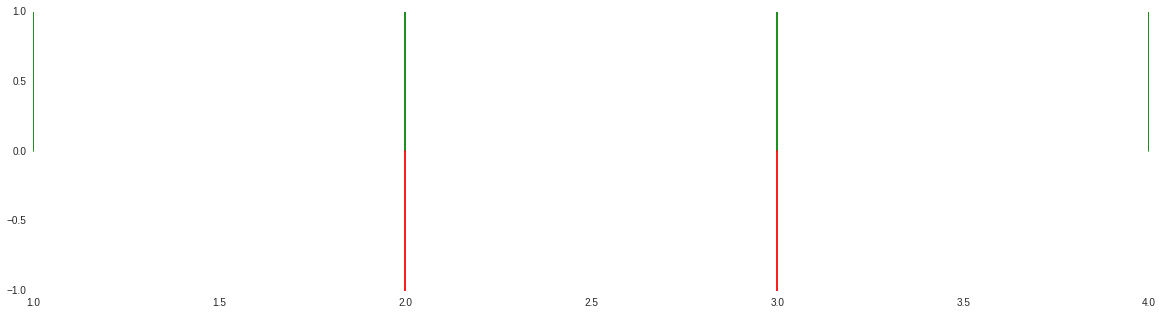

In [59]:
plot_median_range([1,2,3,4])

Median range (112.2, 112.2)


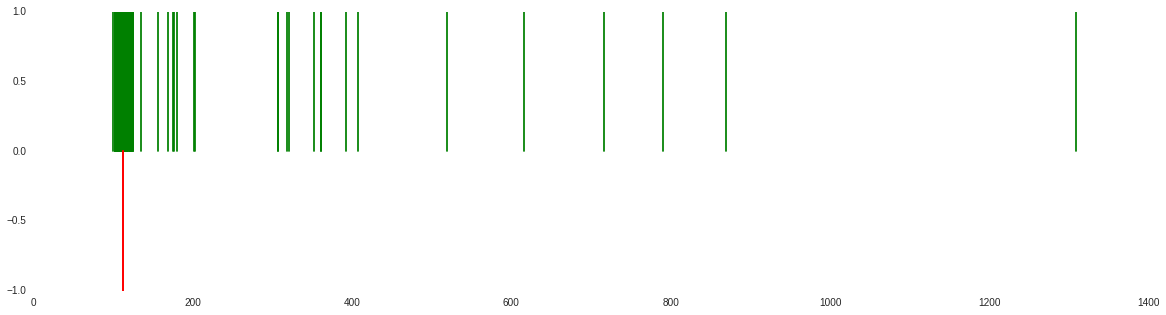

In [61]:
print "Median range", median_range(X)
plot_median_range(X)

In [62]:
# Median is little affected by outliers
print median_range(list(X) + [20000])

(112.2, 112.2)


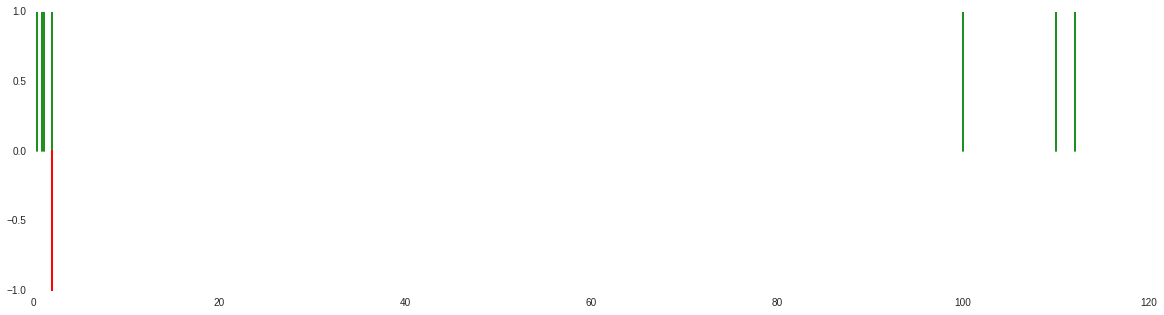

In [65]:
# Median is always a in the dataset
# -> Mean value was in the middle of the graph
plt.figure(figsize=(14,2))
plot_median_range([1,2,0.4,1.2,100,110,112])
plt.show()

# General Definition of Quantiles
Let $0\leq q \leq 1$ be a real number. A $q$-quantile for $X$ is a value $y$ such that, if

$$ \#\{i \,|\, x_i \leq y \} \geq q \cdot n  $$

and

$$ \#\{i \,|\, x_i \geq y \} \geq (1-q) \cdot n $$

Roughly speaking, $y$ divides $X$ in $q \cdot n$ samples that are lower than $y$ and $(1-q) \cdot n$ samples that are larger than $y$.

Remarks:

* Quantiles always exists
* Non unique (like median)
* Lot's of ways to choose a quantile function, i.e. interpolate between $s_a$ and $s_b$ cf.  
  http://en.wikipedia.org/wiki/Quantile#Estimating_the_quantiles_of_a_population

In [66]:
# Computation of Quantiles

def quantile_range(q,X):
    S = sorted(X)
    n = len(X)
    upper_d = int(math.ceil(q * (n + 1)))
    lower_d = int(math.floor(q * (n + 1)))
    # edge cases
    if upper_d == 0: upper_d = 1
    if upper_d == n+1: upper_d = n
    if lower_d == 0: lower_d = 1
    if lower_d == n+1: lower_d = n
    return (S[lower_d-1], S[upper_d-1])

def quantile(q,X):
    a,b = quantile_range(q,X)
    return (a+b)/2 # mid point quantile

def plot_quantile_range(q,X):
    plt.figure(figsize=(20,5))
    sns.rugplot(X, color="green", height=1)
    sns.rugplot(quantile_range(q,X), color="red", height=-1)

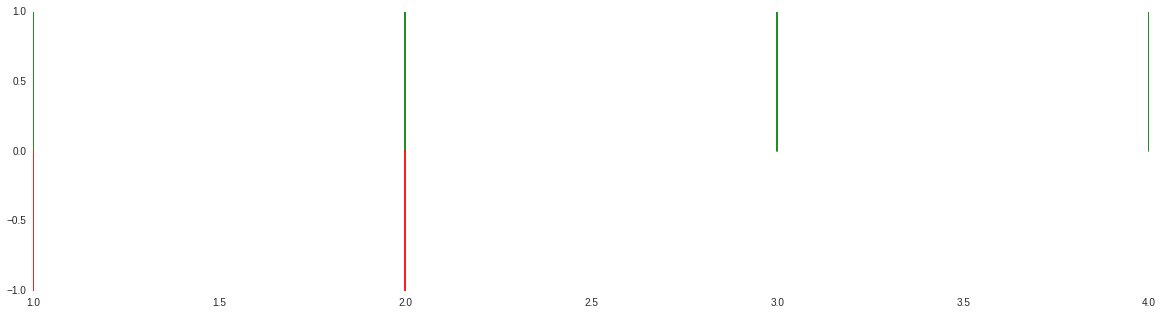

In [11]:
plot_quantile_range(.25,[1,2,3,4])

# Example: Ping Latency Quantiles

* Plot of (Twitter) ping latencies
* With Quantiles as horizontal lines
  - Q(1) = max
  - Q(0.99)
  - Q(0.95)

<img src="img/Circonus_Quantiles.png">

# Example: Quantiles for a Hisogram metric

* Q(0.25) 
* Q(0.5) - Median
* Q(0.75)

<img src="img/Circonus_Histogram_Box.png"/>

# IQR and Outliers

The interquartile range of a sample X is defined as:

`IQR(X) = Q(0.75,X) - Q(0.25,X)`

It is a robust measure for variance of the data. Good alternative to standard / mean deviation.

**Def.** (Tukey, 1969) a k-outlier is a data point X which is either

* larger than `Q(0.75) + k * IQR(X)` or
* smaller than `Q(0.25) - k * IQR(X)`.

An outlier (without k) is an 1.5-outlier.

In [20]:
def IQR(X): return quantile(0.75,X)-quantile(0.25,X)

def outliers(X, k=1.5):
    iqr = IQR(X)
    lower_bound = quantile(0.25,X) - k * iqr
    upper_bound = quantile(0.75,X) + k * iqr
    out = []
    for x in X:
        if x < lower_bound: out.append(x)
        if x > upper_bound: out.append(x)
    return out

22


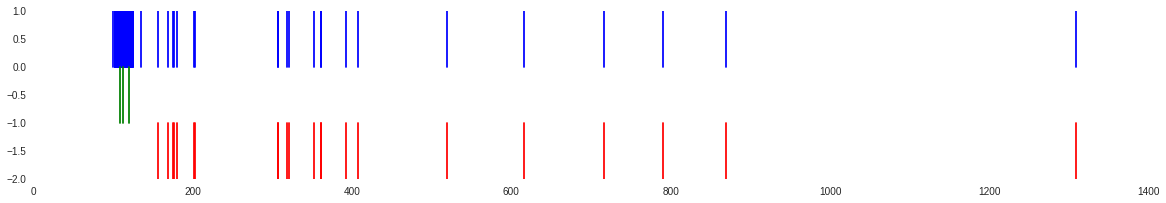

In [49]:
X = np.genfromtxt("DataSets/WebLatency.csv", delimiter=",")[:,2][:200]
O = outliers(X,1.5)
print len(O)

plt.figure(figsize=(20,3))
sns.rugplot(X, height=1, color="blue")
sns.rugplot([quantile(0.25,X), quantile(0.5,X),quantile(0.75,X)], color="green", height=-1)
if len(O) > 0: sns.rugplot(O, height=-1, color="red")

# Tukey's Boxplots

Show:

* Median
* Box around 0.25 and 0.75 Quantiles
* "whiskers" from min to max
* points for outliers

Allows visual clues:

* Where is the data concentracted?
* How far is it spread?
* How skew is the data?

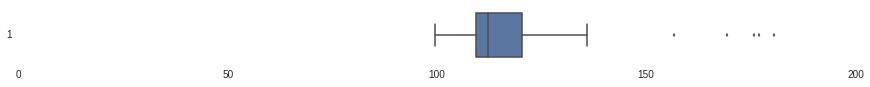

In [51]:
# Tukey Boxplots show outliers as 'points' outside the whiskers
plt.figure(figsize=(15,1))
sns.boxplot(X, vert=False).set_xlim(0,200)
plt.show()

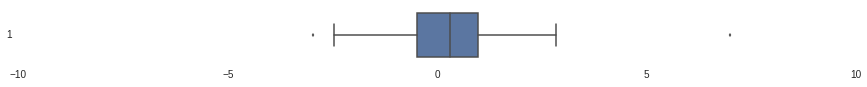

In [42]:
# Normal data
N = [np.random.normal() for x in xrange(100)]

# Add outlier
NO = N + [7]

plt.figure(figsize=(15,1))
sns.boxplot(NO, vert=False).set_xlim(-10,10)
plt.show()

# Note, that IQR and Median are not affected by the outlier!